# RECOMMENDATION TOOLS LastFM

Prof. Philipp Borchert

Team:

Sripada Sai Sumanth

Aazad Ghoslya

Remi Colombier

In [415]:
#IMPORTING

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# NLP packages
import nltk # pip install nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer


from IESEG import eval
from IESEG.model import ContentBased
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, KNNBasic, SVD, SVDpp
from surprise import accuracy
from surprise import BaselineOnly
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise.model_selection.search import GridSearchCV
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ssripada1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssripada1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


READING THE DATA

In [276]:
artists = pd.read_table("Artists.dat")
tags    = pd.read_table("tags.dat" , encoding='latin-1')
user_artists = pd.read_table("user_artists.dat")
user_tags = pd.read_table("user_taggedartists.dat")

### Artists

In [278]:
artists.head(2)

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg


In [279]:
artists['name'].nunique()

17632

### User Artists

In [219]:
user_artists.head(2)

,userID,artistID,weight
0,2,51,13883
1,2,52,11690


In [282]:
#### Check for userID
ua = user_artists.groupby('userID').size()
ua

userID
2       50
3       50
4       50
5       50
6       50
        ..
2095    50
2096    50
2097    50
2099    50
2100    50
Length: 1892, dtype: int64

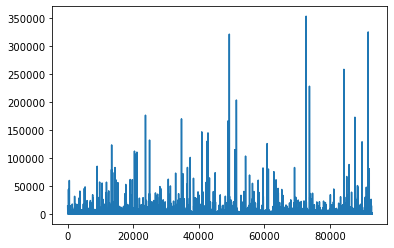

In [283]:

#### User_artists weights
ax = user_artists['weight'].plot.line()

### User Tags

In [220]:
user_tags.head(2)

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009


#### Check for most common artists

In [551]:
new = tags.merge(user_tags, on = 'tagID', how='left')
new.head(2)

,tagID,tagValue,userID,artistID,day,month,year
0,1,metal,4.0,918.0,1.0,5.0,2008.0
1,1,metal,12.0,181.0,1.0,5.0,2010.0


In [552]:
#getting the tagvalues and the respective aggragated count
most_common_tag = (
    new
    .groupby("artistID")["tagValue"]
    .value_counts().rename("count").reset_index()
    .groupby("artistID")
    .first()["tagValue"]
)

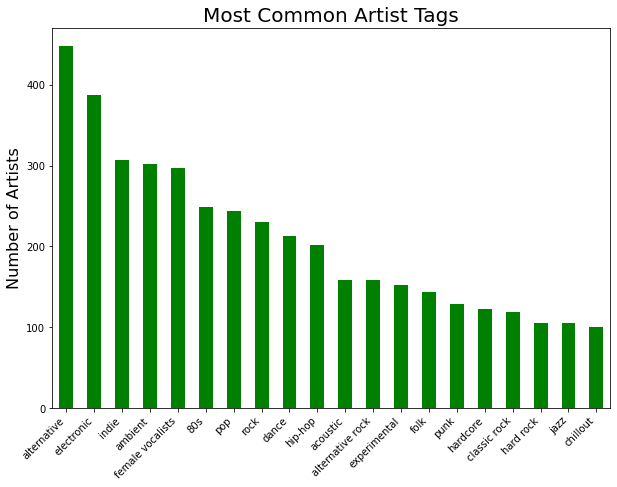

In [557]:
#Plot for the Most Common Artist Tags

fig, ax = plt.subplots(figsize=(10, 7))
most_common_tag.value_counts().head(20).plot.bar(ax=ax, color =  'green')
plt.title("Most Common Artist Tags", fontsize=20)
plt.ylabel("Number of Artists", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.show()

### Tags

In [221]:
tags.head(2)

,tagID,tagValue
0,1,metal
1,2,alternative metal


In [281]:
print(tags['tagID'].nunique())
print(tags['tagValue'].nunique())

11946
11946


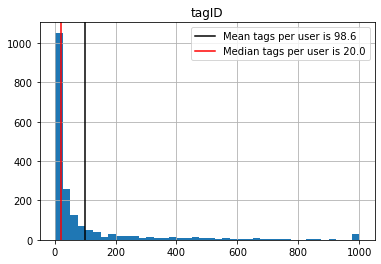

In [287]:
# average number of tags per user

reviews_item = user_tags.groupby('userID').agg({'tagID':'count'})

#histogram
reviews_item.clip(upper=1000).hist(bins=40)

plt.axvline(x=reviews_item.mean().item(), label=f"Mean tags per user is {reviews_item.mean().item():.1f}", c="k")
plt.axvline(x=reviews_item.median().item(), label=f"Median tags per user is {reviews_item.median().item():.1f}", c="r")
plt.legend()

Scaling the weights 

- Weights of the Artists looks very skewed, hence we tried to scale the data using Min Max Scaling 

In [298]:
# Function for  min-max scaling 
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

In [299]:
df_to_scale = user_artists['weight']
df_to_scale = pd.DataFrame(df_to_scale)
df_to_scale.head(2)

,weight
0,13883
1,11690


In [300]:
# call the min_max_scaling function
df_normalized = min_max_scaling(df_to_scale)
df_normalized.head(3)

,weight
0,0.039360
1,0.033142
2,0.032181


- Here we are using the quantiles to get the percentiles and based on that we are dividing the weights into 5 different categories for 5 Ratings

- Here we can see 1.0 is the max value and 0 is the Min value

0.2    0.000232
0.4    0.000530
0.6    0.001012
0.8    0.002163

are the four quantiles values based on which we are giving ratings.

In [301]:
print(df_normalized.weight.max())
print(df_normalized.weight.min())
df_normalized.weight.quantile([0.20,0.40,0.60,0.80])

1.0
0.0


0.2    0.000232
0.4    0.000530
0.6    0.001012
0.8    0.002163
Name: weight, dtype: float64

Ratings 1-5

In [305]:
user_artists['rating']  = 0
user_artists.loc[user_artists['weight']  <= 0.000232 ,['rating']] = 1
user_artists.loc[(user_artists['weight'] > 0.000232) & (user_artists['weight']<= 0.000530) ,['rating']] = 2
user_artists.loc[(user_artists['weight'] > 0.000530 ) & (user_artists['weight']<= 0.001012) ,['rating']] = 3
user_artists.loc[(user_artists['weight']  > 0.001012) & (user_artists['weight']<= 0.002163) ,['rating']] = 4
user_artists.loc[user_artists['weight']  > 0.002163 ,['rating']] = 5

In [306]:
user_artists['weight'] = df_normalized
user_artists.head(3)

,userID,artistID,weight,rating
0,2,51,0.039360,5
1,2,52,0.033142,5
2,2,53,0.032181,5


In [307]:
user_artists.groupby('rating').size()

rating
1    18560
2    18537
3    18526
4    18633
5    18578
dtype: int64

### Check the distribution of the rating
So after the ratings are divided based on the quantiles, we have almost equal number of ratings as we can see below.

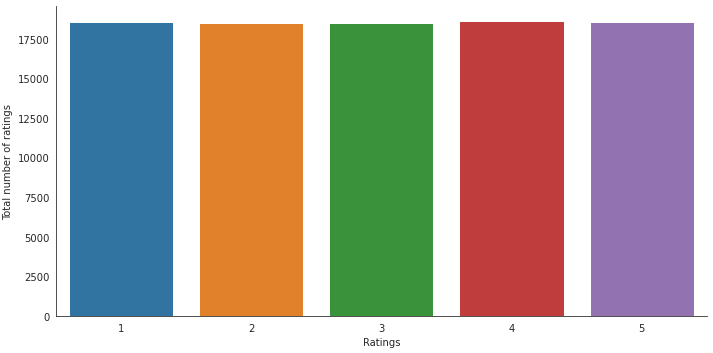

In [554]:
#Plot for the Cout of each Ratings
with sns.axes_style('white'):
    g = sns.catplot("rating", data=user_artists, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
    g.set_xlabels("Ratings")
    g.set_titles("Ratings Distribution")

Subsetting the data and only taking userID , artistID , rating

In [311]:
#subsetting the data 
data_df = user_artists[['userID','artistID','rating']]
data_df.head(3)

#Renaming the rating to raw_ratings
data_df = data_df.rename(columns={'rating': 'raw_ratings'})

#split the data into train and test 30 - 70
train , test = train_test_split(data_df , test_size=0.3,random_state= 42)

In [312]:
# reset index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(data_df.shape)
print(train.shape)
print(test.shape)

(92834, 3)
(64983, 3)
(27851, 3)


surprise format - using the Reader and load_from_df objects , transformed the datasets into surprise format

In [313]:
reader = Reader(rating_scale= (1,5))
train_df = Dataset.load_from_df(train,reader).build_full_trainset()
test_df = list(test.itertuples(index=False,name = None))

# COLLABORATIVE FILTERING

## KNNBasic User Based

It recommends items based on the common preferences of the users and their profiles. Within the KNNBasic the parameter ‘user_based = True’  is to be set for the used based model.

In [314]:
#USER BASED

np.random.seed(50)
#cosine similarity
sim_options = {'name':'cosine','user_based':True}
algo_ub = KNNBasic(k = 20,min_k=5 , sim_options= sim_options)

#Fit the Model
algo_ub.fit(train_df)

#Predicting on Test data
prediction_ub = algo_ub.test(test_df)
prediction_df = pd.DataFrame(prediction_ub)
prediction_df.head()

#Accuracy MAE & RMSE
print(accuracy.mae(prediction_ub, verbose=True))
print(accuracy.rmse(prediction_ub,verbose = True))

Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  1.2019
1.2019404337265027
RMSE: 1.4107
1.410693680833301


## KNNBasic Item Based

In [315]:
#ITEM BASED

np.random.seed(50)
#cosine similarity
sim_options = {'name':'cosine','user_based':False}
algo_ub = KNNBasic(k = 20,min_k=5 , sim_options= sim_options)

#Fit the Model
algo_ub.fit(train_df)

#Predicting on Test data
prediction_ib = algo_ub.test(test_df)
prediction_df = pd.DataFrame(prediction_ib)
prediction_df.head()

#Accuracy MAE & RMSE
print(accuracy.mae(prediction_ib, verbose=True))
print(accuracy.rmse(prediction_ib,verbose = True))

Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.8352
0.8352482292156409
RMSE: 1.0723
1.0722821335166353


## ALS(Alternating Least Square)

ALS works by optimizing the optimizing the ratings obtained either according to users or according to items. It decomposes the rating matrix into two factors user matrix and item matrix.
•	It minimizes the least squared error of the observed ratings.


In [316]:
# ALS 
from surprise import BaselineOnly
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }

#Baseline 
algo_als = BaselineOnly(bsl_options=bsl_options)

#Fit train data
model = algo_als.fit(train_df)

#Predictions 
predictions_als = algo_als.test(test_df)
prediction_df3 = pd.DataFrame(predictions_als)
prediction_df3.head()

#Accuracy
accuracy.rmse(predictions_als)

Using ALS
Estimating biases using als...
RMSE: 0.8932


0.8931595731992387

SVD

In [317]:
#SVD 
svd = SVD()
#Fit train data
algo_svd = svd.fit(train_df)

#Predictions
prediction_svd = algo_svd.test(test_df)
prediction = pd.DataFrame(prediction_svd)

print(accuracy.rmse(prediction_svd))
print(accuracy.mae(prediction_svd, verbose=True))

RMSE: 0.8550
0.8550437139164208
MAE:  0.6712
0.6711584384605545


## SVDpp

- Considered as one of the most powerful recommendation systems.
- It’s a form of Matrix Factorization that uses Gradient Descent to create predictions for user Ratings while minimizing error between the       predicted and the actual ratings 
- Gradient descent minimizes the RMSE to a great extent when predicting new ratings.
- Just like any other model, after splitting the data we fit the model on train data and test the predictions on test dataset.
 Parameters of the GridSearchCV to SVD Model can be used to tune the model further.


In [319]:
#SVDpp FIRST RUN
svdpp = SVDpp()

algo_svdpp = svdpp.fit(train_df)

#Predictions
predictions_svdpp = algo_svdpp.test(test_df)
svd_pred = pd.DataFrame(predictions_svdpp)
svd_pred.head()

#Accuracy MAE & RMSE
print(accuracy.mae(predictions_svdpp, verbose=True))
print(accuracy.rmse(predictions_svdpp,verbose = True))

MAE:  0.6464
0.646436060832938
RMSE: 0.8415
0.8415428309028137


## CO-CLUSTERING

The algorithm co clustering creates clusters across the users-item matrix. The idea is to make clusters according to the similarities of the pairwise interactions. This algorithm allows users or items to be part of several clusters at the same time, hence the name co-clustering. Then we calculate the estimated ranking of each user or item for each cluster. 

In [320]:
# Co - clustering
coclus = CoClustering()
algo_coclus  = coclus.fit(train_df)

#Prediction coclus 
coclus_prediction = algo_coclus.test(test_df)
prediction_coclus = pd.DataFrame(coclus_prediction)
print(accuracy.rmse(coclus_prediction))
print(accuracy.mae(coclus_prediction, verbose=True))

RMSE: 1.0216
1.0216057147644062
MAE:  0.7862
0.7862178637979814


Evaluation of the Models

In [321]:
user_based   = eval.evaluate(prediction= prediction_ub,  topn = 10 , rating_cutoff= 5, excl_impossible=True)
item_based  = eval.evaluate(prediction= prediction_ib,  topn = 10 , rating_cutoff= 5, excl_impossible=True)
als  = eval.evaluate(prediction= predictions_als,  topn = 10 , rating_cutoff= 5, excl_impossible=True)
SVD    = eval.evaluate(prediction= prediction_svd,   topn = 10 , rating_cutoff= 5, excl_impossible=True)
SVDpp  = eval.evaluate(prediction= predictions_svdpp,  topn = 10 , rating_cutoff= 5, excl_impossible=True)
coclus = eval.evaluate(prediction= coclus_prediction,topn = 10 , rating_cutoff= 5, excl_impossible=True)

Excluded 9182 (27851) samples. 18669 remaining ...
Excluded 9182 (27851) samples. 18669 remaining ...
Excluded 7125 (27851) samples. 20726 remaining ...
Excluded 7125 (27851) samples. 20726 remaining ...
Excluded 0 (27851) samples. 27851 remaining ...
Excluded 0 (27851) samples. 27851 remaining ...
Excluded 0 (27851) samples. 27851 remaining ...
Excluded 0 (27851) samples. 27851 remaining ...
Excluded 0 (27851) samples. 27851 remaining ...
Excluded 0 (27851) samples. 27851 remaining ...
Excluded 0 (27851) samples. 27851 remaining ...
Excluded 0 (27851) samples. 27851 remaining ...


Results for Colaborative Filtering Approach Algorithms

- Out of All, SVDpp has the best performance considering the lowest RMSE

In [349]:
eval_results = pd.DataFrame()
eval_results['user_based'] = pd.DataFrame(user_based['value'])
eval_results['item_based'] = pd.DataFrame(item_based['value'])
eval_results['als'] = pd.DataFrame(als['value'])
eval_results['SVD'] = pd.DataFrame(SVD['value'])
eval_results['SVDpp'] = pd.DataFrame(SVDpp['value'])
eval_results['colcus_eval'] = pd.DataFrame(coclus['value'])


eval_results

,user_based,item_based,als,SVD,SVDpp,colcus_eval
RMSE,1.411652,0.925803,0.893160,0.855044,0.841543,1.021606
MAE,1.207146,0.711353,0.735600,0.671158,0.646436,0.786218
Recall,0.000000,0.124921,0.010741,0.052990,0.090047,0.144826
Precision,NaN,0.978477,0.952381,0.939683,0.936685,0.763928
F1,NaN,0.221556,0.021243,0.100322,0.164299,0.243491
NDCG@10,0.821275,0.820664,0.837394,0.836453,0.839262,0.831483


In [422]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd



# CROSS VALIDATION FOR SVD and SVDpp

In [558]:
models  = [ ('svd', SVD()), ('svdpp', SVDpp()) ]
dfs     = []
results = []
names   = []
#scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']

for name, model in models:
        
        cv_results = cross_validate(model ,Dataset.load_from_df(train,reader),measures=['RMSE', 'MAE'],cv=5, verbose=False, n_jobs=-1)
        print(name)
        
        results.append(cv_results)
        names.append(name)

        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name

        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
final


svd
svdpp


,test_rmse,test_mae,fit_time,test_time,model
0,0.867027,0.690125,3.843857,0.115983,svd
1,0.865491,0.688813,4.038660,0.100916,svd
2,0.879238,0.695492,3.754026,0.091345,svd
3,0.869963,0.689249,3.921702,0.090982,svd
4,0.879173,0.697183,3.718243,0.116474,svd
5,0.848184,0.657391,34.889505,0.619313,svdpp
6,0.857569,0.664417,35.455840,0.406790,svdpp
7,0.852406,0.661542,35.223544,0.429820,svdpp
8,0.855132,0.661581,35.049096,0.707014,svdpp
9,0.862206,0.664251,35.207806,0.637122,svdpp


In [447]:
# taking the separate df for both svd and svdpp for CV
svd = final[final['model'] == 'svd']
svpp = final[final['model'] == 'svdpp']

CV SVD

In [448]:
pd.DataFrame(svd.mean()).transpose()

,test_rmse,test_mae,fit_time,test_time
0,0.873129,0.692513,6.058778,0.22292


CV SVDpp

In [449]:
pd.DataFrame(svpp.mean()).transpose()

,test_rmse,test_mae,fit_time,test_time
0,0.854933,0.661693,65.811866,0.959362


# CONTENT BASED 

Content based filtering is another approach in the collaborative Filtering that attempts to guess what user may like based on the historical data of that user. It uses the keywords and attributes assigned to objects in a database and matching them to a user profile. 

In [335]:
user_artists_tags = pd.merge(user_tags,tags , on = 'tagID')

In [336]:
user_artists_tags.head(2)

,userID,artistID,tagID,day,month,year,tagValue
0,2,52,13,1,4,2009,chillout
1,2,63,13,1,4,2009,chillout


Taking the unique values of the tagValue and grouping by Artists

In [326]:
tags_grouped = user_artists_tags.groupby('artistID', as_index=False).agg({'tagValue' : 'unique'})

In [337]:
tags_grouped['tagValue'] = tags_grouped['tagValue'].astype(str).str[1:-1]

In [338]:
tags_grouped

,artistID,tagValue
0,1,j-rock' 'visual kei' 'gothic' 'japanese' 'weeabo' 'jrock'\n 'better than lady gaga
1,2,electronic' 'ambient' 'seen live' 'german' 'industrial' 'gothic'\n 'gothic rock' 'dark' 'darkwave' 'vocal' 'true goth emo
2,3,black metal' 'norwegian black metal' 'true norwegian black metal'\n 'very kvlt' 'norsk arysk metal' 'saxophones
3,4,rock' 'metal' 'gothic metal' 'j-rock' 'visual kei' 'gothic' 'japanese'\n 'gothic japanese' 'bazarov
4,5,gothic' 'gothic rock' 'darkwave' 'deathrock' 'covers
...,...,...
12518,18737,80s' 'alternative' 'electronica' 'noise' 'trip beat
12519,18739,electronic' 'trip-hop' 'rock' 'alternative' 'alternative rock' 'uk'\n 'electronica' 'favorite
12520,18740,ebm' 'industrial
12521,18741,experimental' 'dead music


In [339]:
# Tokenize, case conversion & only alphabetic
tokens = tags_grouped['tagValue'].apply(lambda txt: [word.lower() for word in word_tokenize(str(txt)) if word.isalpha()])

In [340]:
#stemming
stemmer = SnowballStemmer("english")

# remove stopwords
# stem
token_stem = tokens.apply(lambda lst_token: [stemmer.stem(tok) for tok in lst_token if  len(tok) > 2])

TFIDF

In [341]:
# TFIDF vectorizer
tfidf = TfidfVectorizer(min_df=5)

# apply tf-idf vectorizer -> document-term-matrix in sparse format
dtm = tfidf.fit_transform([" ".join(x) for x in token_stem])

print(dtm.shape)

df_dtm = pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names_out(), index=tags_grouped.artistID	)
df_dtm.head()

(12523, 841)


,about,absolut,abstract,acid,acoust,actual,adam,africa,african,again,...,yeah,yet,york,yorkshir,you,young,your,yourself,zealand,zone
artistID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [420]:
# count word occurences in text preprocessed corpus 
from collections import Counter

res_l = []
for l in token_stem: res_l+=l

token_dict = Counter(res_l)
token_dict = {k: v for k, v in sorted(token_dict.items(), key=lambda item: item[1], reverse=True)}
token_Df = pd.DataFrame(token_dict.items(), columns=['token', 'count'])[:10]
token_Df

,token,count
0,rock,6564
1,metal,2985
2,pop,2544
3,vocalist,2338
4,song,1883
5,electron,1374
6,live,1001
7,music,754
8,the,744
9,chillout,734


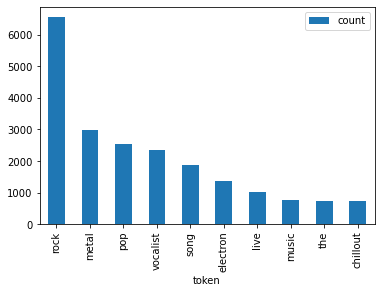

In [560]:
# Check the distribution of the tokens

x = token_Df.plot.bar(x = 'token', y = 'count')

Content Based Fitting the Model

In [343]:
# content-based
cb = ContentBased(NN=10)
cb.fit(df_dtm)

In [ ]:
#Fitting the content based on the train set 
cb.fit_ratings(train_df)

In [345]:
#Predicting on the test set 
cb_pred = cb.test(test_df)

In [346]:
# compute metrics - Content Based
cb_res = eval.evaluate(cb_pred, topn=10, rating_cutoff=5).rename(columns={'value':'Content_based_10'})
cb_res

,Content_based_10
RMSE,0.969124
MAE,0.736876
Recall,0.145900
Precision,0.971395
F1,0.253696
NDCG@10,0.856146


In [267]:
from IESEG import eval

Evaluating Content Based 

In [350]:
content_based = eval.evaluate(prediction= cb_pred,topn = 10 , rating_cutoff= 5, excl_impossible=True)


Excluded 3918 (27851) samples. 23933 remaining ...
Excluded 3918 (27851) samples. 23933 remaining ...


Results

- From the Results we can see that Content based performs better than ot of models but in our case, SVD still performs better than any other Model

In [351]:
#concating content based results 
eval_results['cont_based_eval'] = pd.DataFrame(content_based['value'])
eval_results  

,user_based,item_based,als,SVD,SVDpp,colcus_eval,cont_based_eval
RMSE,1.411652,0.925803,0.893160,0.855044,0.841543,1.021606,0.873023
MAE,1.207146,0.711353,0.735600,0.671158,0.646436,0.786218,0.660316
Recall,0.000000,0.124921,0.010741,0.052990,0.090047,0.144826,0.162125
Precision,NaN,0.978477,0.952381,0.939683,0.936685,0.763928,0.971395
F1,NaN,0.221556,0.021243,0.100322,0.164299,0.243491,0.277872
NDCG@10,0.821275,0.820664,0.837394,0.836453,0.839262,0.831483,0.872116


# Hybrid 

This is a special type of recommendation system which is a combination of content based and collaborative approaches. This approach might help in mitigating the issues of collaborative filtering and can be more effective at times.
Hybrid model can be done in multiple ways either by choosing two collaborative models or one collaborative model combined with the content based using content and collaborative-based methods to generate predictions separately and then combining the prediction or we can just add the capabilities of collaborative-based methods to a content-based approach. Here we have tried both the approaches and observed that the combination of Content based, and Collaborative with the Random Forest Model produced better results.


In [74]:
user_artists.head(5)

,userID,artistID,weight,rating
0,2,51,0.039360,5
1,2,52,0.033142,5
2,2,53,0.032181,5
3,2,54,0.029201,5
4,2,55,0.025467,5


In [75]:
user_artists = user_artists[['userID','artistID','rating']]

In [ ]:
# content-based
cb = ContentBased(NN=10)
cb.fit(df_dtm)
cb.fit_ratings(train_df)
cb_pred = cb.test(test_df)

# item-based
options = {'name':'cosine', 'user_based':False}
ib = KNNBasic(k=15, min_k=5, sim_options=options, random_state=42)
ib.fit(train_df)
ib_pred = ib.test(test_df)

# svd
svd = SVD()
svd.fit(train_df)
mf_pred = svd.test(test_df)

#svdpp
svdpp.fit(train_df)
svdpp_pred = svdpp.test(test_df)

models = {"Content_based":cb_pred, "Item_based":ib_pred,"SVD": mf_pred ,"SVP_PP" :svdpp_pred }
overview = pd.concat([eval.evaluate(mod, topn=5, rating_cutoff=5) for mod in models.values()], axis=1)
overview.columns = list(models.keys())
overview

In [565]:
overview

,Content_based,Item_based,SVD,SVP_PP
RMSE,0.969124,1.074782,0.853805,0.843264
MAE,0.736876,0.834757,0.670040,0.647726
Recall,0.145900,0.108127,0.053706,0.088256
Precision,0.971395,0.977346,0.923077,0.940840
F1,0.253696,0.194713,0.101506,0.161375
NDCG@5,0.871632,0.855155,0.852133,0.855042


# Cross Validation for SVDpp

In [566]:
from surprise.model_selection import cross_validate

crs_val = pd.DataFrame(cross_validate(svdpp ,Dataset.load_from_df(train,reader),measures=['RMSE', 'MAE'],cv=5, verbose=False, n_jobs=-1))

In [567]:
#cross validation result for SVDpp
pd.DataFrame(crs_val.mean()).transpose()

,test_rmse,test_mae,fit_time,test_time
0,0.855016,0.661148,234.441282,3.05262


In [569]:
# Combine predictions (mean)

# extract predictions content-based and item-based
df_pred_cb, df_pred_ib = pd.DataFrame(cb_pred), pd.DataFrame(ib_pred)

df_hybrid = df_pred_cb.copy()
df_hybrid['est'] = (np.array(df_pred_cb['est']) + np.array(df_pred_ib['est'])) / 2

df_hybrid.head()

,uid,iid,r_ui,est,details
0,1761,16513,1,3.000816,"{'was_impossible': True, 'reason': 'User or item unknown'}"
1,915,3746,4,3.274275,{'was_impossible': False}
2,644,8841,1,3.000816,"{'was_impossible': True, 'reason': 'User or item unknown'}"
3,1736,5270,3,3.310576,{'was_impossible': False}
4,1042,295,5,3.144547,{'was_impossible': False}


In [584]:
eval.evaluate(df_hybrid, topn=5, rating_cutoff=5)

,value
RMSE,0.975423
MAE,0.771594
Recall,0.111529
Precision,0.998397
F1,0.200644
NDCG@5,0.850633


# GridSearchCV for SVDpp

In [549]:
np.random.seed(50)
param_grid = {'n_factors' : [100,200],'n_epochs':[50,100],'lr_all': [0.005, 0.010],
              'reg_all': [0.1,0.4]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

algo_gs = Dataset.load_from_df(train,reader)

#fit
gs.fit(algo_gs)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8700949836625449
{'n_factors': 100, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.1}


# Linear Model - Hybrid 1

In [360]:
# training set for Linear Regression model
lr_train = df_pred_ib[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'ib_pred'})
lr_train['cb_pred'] = df_pred_cb['est']
lr_train.head()

,target,ib_pred,cb_pred
0,1,2.999862,3.001771
1,4,2.999862,3.548689
2,1,2.999862,3.001771
3,3,2.999862,3.621291
4,5,3.396237,2.892857


In [361]:
# Train Linear Regression model
from sklearn.linear_model import LinearRegression

X, y = lr_train.loc[:,lr_train.columns != 'target'], lr_train[['target']]

lr_model = LinearRegression().fit(X,y)

In [362]:
##### Hybrid - Linear Regression model
# get test set
lr_test = df_pred_ib[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'ib_pred'})
lr_test['cb_pred'] = df_pred_cb['est']
X_test, y_test = lr_test.loc[:,lr_test.columns != 'target'], lr_test[['target']]

# predict
lr_pred = lr_model.predict(X_test)

# transform in surprise format
df_lr = df_pred_ib.copy()
df_lr['est'] = lr_pred

In [363]:
# Evaluate

models = {"Content_Based":cb_pred, "Artist_Based":ib_pred, "SVD" : mf_pred ,"SVD_PP": svdpp2_pred ,"Hybrid_CB_IB":df_hybrid, "Hybrid_LR":df_lr}
overview2 = pd.concat([eval.prediction_metrics(pred) for pred in models.values()], axis=1)
overview2.columns = list(models.keys())
overview2

,Content_Based,Artist_Based,SVD,SVD_PP,Hybrid_CB_IB,Hybrid_LR
RMSE,0.969124,1.074782,0.854379,0.837949,0.975423,0.956128
MAE,0.736876,0.834757,0.670775,0.641852,0.771594,0.739426


# Random Forest - Hybrid 2

In [364]:
# copy lr train set
rf_train = lr_train.copy()
rf_train.head()

,target,ib_pred,cb_pred
0,1,2.999862,3.001771
1,4,2.999862,3.548689
2,1,2.999862,3.001771
3,3,2.999862,3.621291
4,5,3.396237,2.892857


In [378]:
from sklearn.ensemble import RandomForestRegressor

X, y = rf_train.loc[:,rf_train.columns != 'target'], np.array(rf_train['target'])

# fit random forest model
rf_model = RandomForestRegressor(max_depth=20, n_estimators=1000).fit(X,y)

In [379]:
# predict
rf_pred = rf_model.predict(X_test)

# transform in surprise format
df_rf = df_pred_ib.copy()
df_rf['est'] = rf_pred

In [380]:
# Evaluate
rf_res = eval.prediction_metrics(df_rf).rename(columns={'value':'Hybrid_RF'})

In [381]:
# Display Overview
overview3 = pd.concat([overview2, rf_res], axis=1)
overview3

,Content_Based,Artist_Based,SVD,SVD_PP,Hybrid_CB_IB,Hybrid_LR,Hybrid_RF
RMSE,0.969124,1.074782,0.854379,0.837949,0.975423,0.956128,0.650241
MAE,0.736876,0.834757,0.670775,0.641852,0.771594,0.739426,0.471028


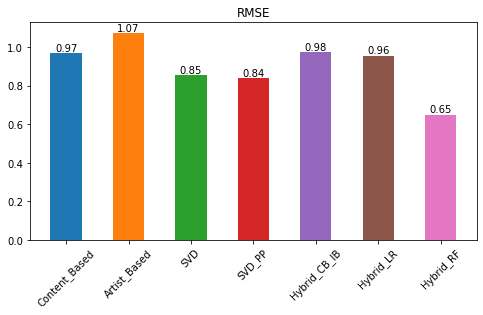

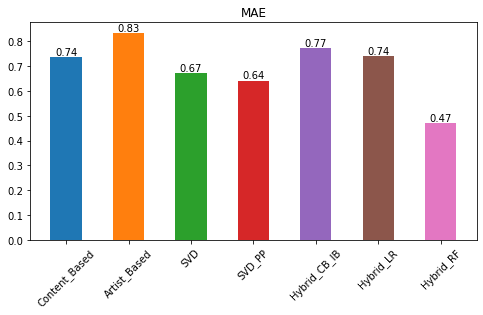

In [571]:
# RMSE and MAE of the Models 
width = .5
for j, row in enumerate(overview3.index):
    fig, ax = plt.subplots(figsize=(8,4))
    x = np.arange(len(overview3.columns))
    for i, col in enumerate(overview3.columns):
        plt.bar(x[i], overview3.iloc[j,i], width, label='col')
        ax.text(x[i], overview3.iloc[j,i], str(round(overview3.iloc[j,i],2)),
                ha='center', va='bottom')
    ax.set_xticks(x)
    ax.set_title(row)
    ax.set_xticklabels(overview3.columns)
    plt.xticks(rotation = 45)
    plt.show()

# Recommending Artsits using the Best Models

Function for top 10 Recommendations

This Functions takes arguments model, train , user , top_n , itemcol and gives the respective recommendations.

In [382]:
def predict_user_topn(model, train, user, topk=10, item_col='item'):
    """
    Returns topk items for specified user.
    Return type: list

    Args[model, train, user, topk, item_col]
    model:      fitted model (surprise package)
    train:      train set used to fit model
    user:       user id
    topk:       topk items to return
    item_col:   column containing item ids 
    """

    # intermediate result dict 
    res = {item_col:[], 'pred':[], 'detail':[]}
    
    # iter through all items contained in train set
    for item in set(train[item_col]) :
        uid, iid, true_r, est, detail = model.predict(user,item)
        if detail['was_impossible']: continue
        # save to result dict
        res[item_col].append(item)
        res['pred'].append(est)
        res['detail'].append(detail)

    return list(pd.DataFrame(res).sort_values('pred', ascending=False)[:topk][item_col])

In [520]:
user_artists.head(2)

,userID,artistID,weight,rating
0,2,51,0.039360,5
1,2,52,0.033142,5


### Recommending top 10 Artists for UserID 10 , using CB

- Here the aim is to recommend artists for a selected user and see how our model performs
- Below is the recommendation using Content based Approach.
- we got the respective artists names and their tag Values 
- and Finally checking what actually the user likes and listens to (from the user_artists data ) and what we are actually recommending.

In [544]:
#Get the Recommendations using the Content Based Model
recom_cb = pd.DataFrame(predict_user_topn(cb, train, 10, topk=10, item_col='artistID'))
recom_cb.columns = ['artistID']

#merge it wit the artists data to get the name of the recommended Artists
recom_cb_merged = recom_cb.merge(artists , left_on= 'artistID' , right_on= 'id')
recom_cb_merged = recom_cb_merged[['artistID','name']]
recom_cb_merged

#getting the tagValue to check the genere of these recommended artists 
cb_recomm = recom_cb_merged.merge(tags_grouped, how= 'left' , on= 'artistID')
cb_recomm

,artistID,name,tagValue
0,173,Placebo,chillout' 'electronic' 'atmospheric' 'pop' 'new wave' 'melancholic'\n 'rock' 'alternative' 'glam...
1,412,blink-182,pop' 'rock' 'alternative' 'alternative rock' 'hard rock' 'post-rock'\n 'seen live' 'pop rock' 'p...
2,211,The Decemberists,rock' 'alternative' 'indie rock' 'singer-songwriter' 'indie' 'acoustic'\n 'country' 'american' '...
3,208,Babyshambles,rock' 'alternative' 'alternative rock' 'indie rock' 'jazz' 'seen live'\n 'singer-songwriter' 'in...
4,424,The Strokes,electronic' 'dance' 'new wave' 'rock' 'alternative' 'alternative rock'\n 'hard rock' 'indie rock...
5,1379,Hurts,chillout' 'electronic' 'dance' 'pop' 'new wave' 'synth pop' 'synthpop'\n 'alternative' 'uk' 'hip...
6,419,Tokyo Police Club,rock' 'alternative' 'indie rock' 'indie' 'post-punk' 'awesome'\n 'male vocalists' 'canadian' 'lo...
7,1048,The Kooks,pop' 'rock' 'alternative' 'alternative rock' 'indie rock' 'uk'\n 'seen live' 'indie' 'british' '...
8,1424,Cat Power,chillout' 'trip-hop' 'atmospheric' 'new wave' 'experimental'\n 'female vocalist' 'rock' 'alterna...
9,416,The National,rock' 'alternative' 'alternative rock' 'indie rock' 'post-rock'\n 'new york' 'seen live' 'indie'...


In [548]:
#Get the Recommendations using the Collaborative Filtering Approach
recom_svd = pd.DataFrame(predict_user_topn(svdpp, train, 10, topk=10, item_col='artistID'))
recom_svd.columns = ['artistID']

#merge it wit the artists data to get the name of the Recommended Artists
recom_svd_merged = recom_svd.merge(artists , left_on= 'artistID' , right_on= 'id')
recom_cb_merged = recom_svd_merged[['artistID','name']]
recom_svd_merged

#getting the tagValue to check the genere of these recommended artists 
svd_recomm = recom_svd_merged.merge(tags_grouped, how= 'left' , on= 'artistID')
svd_recomm  = svd_recomm[['artistID','name','tagValue']]
svd_recomm

,artistID,name,tagValue
0,679,Glee Cast,electronic' 'dance' 'pop' 'female vocalist' 'rock' 'alternative' 'funk'\n 'female vocalists' 'si...
1,2940,Dead by April,female vocalist' 'rock' 'alternative' 'alternative rock' 'hard rock'\n 'metal' 'seen live' 'alte...
2,292,Christina Aguilera,electronic' 'dance' 'pop' 'female vocalist' 'rock' 'synthpop'\n 'alternative' 'jazz' 'hip-hop' '...
3,1904,SHINee,pop' 'kpop' 'korean' 'k-pop' 'heart' 'myfavorites-singers'\n 'biggest-voices' 'asian' 'korea
4,227,The Beatles,chillout' 'ambient' 'atmospheric' 'dance' 'pop' 'new wave' '80s'\n 'experimental' 'rock' 'psyche...
5,419,Tokyo Police Club,rock' 'alternative' 'indie rock' 'indie' 'post-punk' 'awesome'\n 'male vocalists' 'canadian' 'lo...
6,6724,John Frusciante,experimental' 'rock' 'alternative' 'alternative rock'\n 'singer-songwriter' 'indie' 'acoustic' '...
7,2044,Sarah Brightman,chillout' 'electronic' 'ambient' 'new age' 'dance' 'pop'\n 'female vocalist' 'melancholic' 'symp...
8,1994,Devin Townsend,ambient' 'experimental' 'alternative' 'progressive metal' 'metal' 'epic'\n 'drone' 'progressive ...
9,4437,梶浦由記,new age' 'j-pop' 'soundtrack' 'epic' 'world' 'dream pop' 'piano'\n 'japanese' 'anime' 'composer'...


checking the tagValue of the artists the user 10 has already Rated. So from this we can understand that the tagValues are common in the Recommended artists and the artists that the user has already Rated. From this we have understood that the model recommendation is as expected.

In [583]:
user_artists_tags[user_artists_tags["userID"]==10]['tagValue']

35788            alternative
35789            alternative
35790            alternative
35791            alternative
35792            alternative
35793            alternative
35794            alternative
41190       alternative rock
67017                  indie
67018                  indie
67019                  indie
67020                  indie
67021                  indie
67022                  indie
67023                  indie
67024                  indie
67025                  indie
71475             good music
71476             good music
71477             good music
71478             good music
71479             good music
71480             good music
71488    death cab for cutie
Name: tagValue, dtype: object

Recommendation for particular user , aggragated rating mean - Checking the variety of Artists our Model is Recommending to the users.
- Here we are taking one userID 10 and aggregating all the ratings(mean) of that user for each of these artists which are actually recommeneded By our Model. So the aim is have the Variety of suggestions instead of Recommending the already rated artists by the user.

In [573]:
test_recomm = user_artists[user_artists['userID'] == 10 ]
recom_grpd = test_recomm.groupby('artistID', as_index=False).agg({"rating": 'mean'})
recom_grpd.head(10)

,artistID,rating
0,154,2.0
1,159,3.0
2,196,5.0
3,199,5.0
4,200,3.0
5,208,3.0
6,217,4.0
7,219,3.0
8,225,5.0
9,228,3.0


Here we can see, as per our Models Recommendations, we have 4 artists where the user have already rated( 3 of them are 5 rating) and 6 artists are new recommendations.
- Recommending Three 5 rated artists suggests that the Model actually considers all the cases where , what actually customers likes and what new and similar artists we can Recommend to the Users.
- This also suggests that the model is recommending the artists to the users as we want it to be.

In [574]:
# This is the merge of the recommended artists by our model and the artists that user have already rated.
merged = recom_cb.merge(recom_grpd, how = 'left' , on= 'artistID')
merged.fillna(0)

,artistID,rating
0,173,0.0
1,412,0.0
2,211,0.0
3,208,3.0
4,424,5.0
5,1379,0.0
6,419,5.0
7,1048,0.0
8,1424,0.0
9,416,5.0


## Most Similar Users

- We are using this function cb.get_most_similar to find out the Most similar artists. this fuction takes the arguments artistID and topn

In [575]:
most_similar = pd.DataFrame(cb.get_most_similar( 419, topn=10))
most_similar.columns = ['artistID']
most_similar

,artistID
0,208
1,6920
2,4059
3,17787
4,7288
5,1379
6,12299
7,8356
8,416
9,9132


Here this suggests that in the most similar artists also we have 2 artists who was already rated by the user an the rest all are similar to the user we are recommending the artists.

In [577]:
recom_grpd.merge(most_similar , how= 'right' , on= 'artistID').fillna(0)

,artistID,rating
0,208,3.0
1,6920,0.0
2,4059,0.0
3,17787,0.0
4,7288,0.0
5,1379,0.0
6,12299,0.0
7,8356,0.0
8,416,5.0
9,9132,0.0


In [504]:
predict_user_topn(svdpp, train, 10, topk=10, item_col='artistID')

[679, 2940, 292, 1904, 227, 419, 6724, 2044, 1994, 4437]

In [505]:
predict_user_topn(cb, train, 10, topk=10, item_col='artistID')


[173, 412, 211, 208, 424, 1379, 419, 1048, 1424, 416]